# Notebook for statistical analysis of model training and performance eval
## Imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from datetime import datetime, timedelta

from agents import MinimaxAgent, RandomAgent, AvoidNextLossAgent, ModelAgent, NeuroevolutionAgent
from environment import ConnectFourEnv
from evaluation_func import EvaluationFunction

## Training performance evaluation
The goal is to visualize the training performance of each model in a graph regarding loss and average return since those metrics were collected.
### Preparing the dataframe

In [2]:
#creating the initial dictionary by grid and loading the train data
dfs = {}
train_data = pd.read_csv('./training_data.csv',index_col=None)

#splitting the training data by model training data
dfs['6by7'] = train_data[train_data['PATH'] == './weights/d6by7.h5']
dfs['8by9'] = train_data[train_data['PATH'] == './weights/d8by9.h5']
dfs['10by11'] = train_data[train_data['PATH'] == './weights/d10by11.h5']
dfs['12by13'] = train_data[train_data['PATH'] == './weights/d12by13.h5']

#making the epoch the index for each dataframe
dfs['6by7'].set_index('EPOCH')
dfs['8by9'].set_index('EPOCH')
dfs['10by11'].set_index('EPOCH')
dfs['12by13'].set_index('EPOCH')

dfs['6by7'].head()

,NAME,MODEL,DATE,EPOCH,EPSILON,AVERAGE LOSS,AVERAGE RETURN,PATH
70,202291716x7200,dqn_6x7,2022-09-17 01:57:32.918758,1,0.844150,69.208893,20.981251,./weights/d6by7.h5
71,202291716x7200,dqn_6x7,2022-09-17 02:01:25.328778,2,0.791767,67.936165,20.893749,./weights/d6by7.h5
72,202291716x7200,dqn_6x7,2022-09-17 02:05:19.146811,3,0.742633,64.035210,21.017500,./weights/d6by7.h5
73,202291716x7200,dqn_6x7,2022-09-17 02:09:15.791874,4,0.696549,68.449409,21.280624,./weights/d6by7.h5
74,202291716x7200,dqn_6x7,2022-09-17 02:13:14.418994,5,0.653325,67.171837,21.578125,./weights/d6by7.h5


### Visualization functions
We write a basic function for visualizing training process in matplotlib and save the figure at a desired path.

In [3]:
def visualize_progress(df, name : str, col_val : str, path : str, show=False):
    '''
    Function to show and also save a graph containing the reward over all episodes.
    :param epoch_returns (list): A list of acerage returns for n epochs (defined as 1000 training steps).
    '''

    x = np.arange(0, len(df))
    y = list(df[col_val])

    plt.style.use('dark_background')

    fig, ax = plt.subplots()
    ax.plot(x,y)

    ax.set_title(f'Training progress for model {name}')
    ax.set_ylabel(f' {col_val} per epoch')
    ax.set_xlabel('Epochs')

    fig.savefig(path)
    
    if show:
        plt.show()

We then run the function for each model we trained:

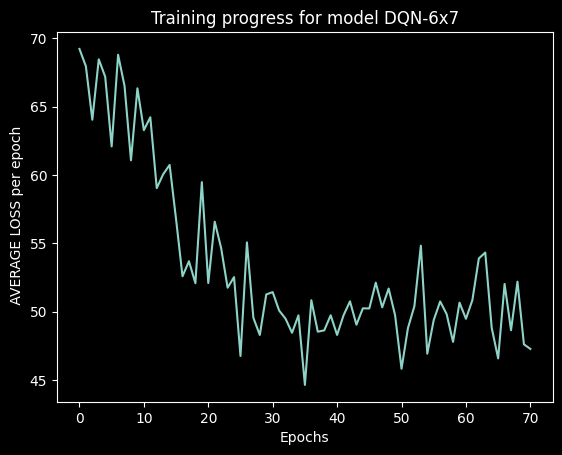

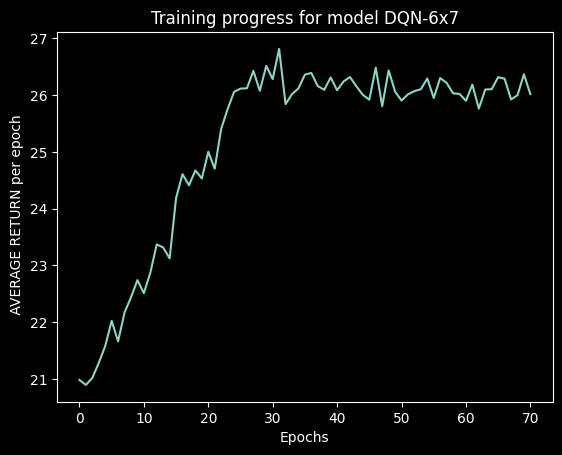

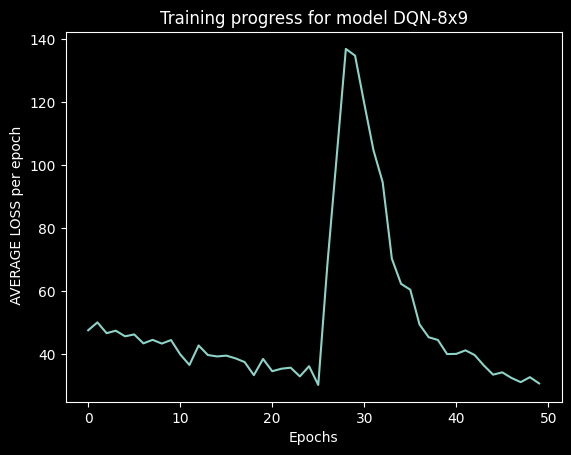

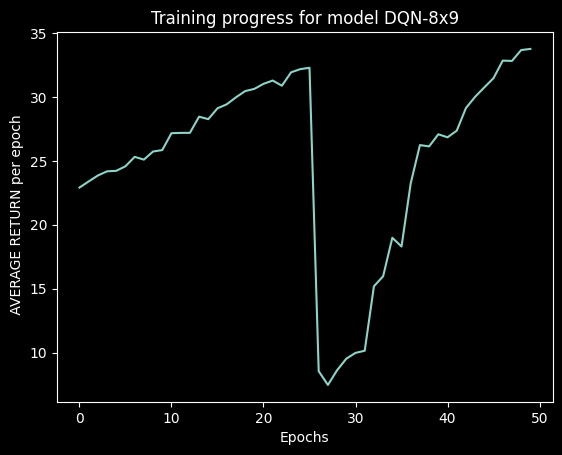

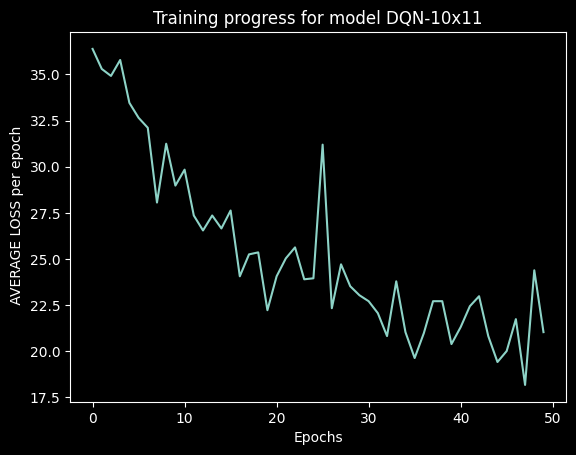

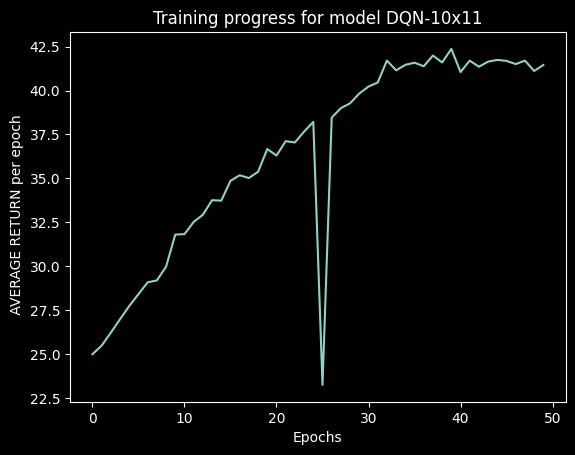

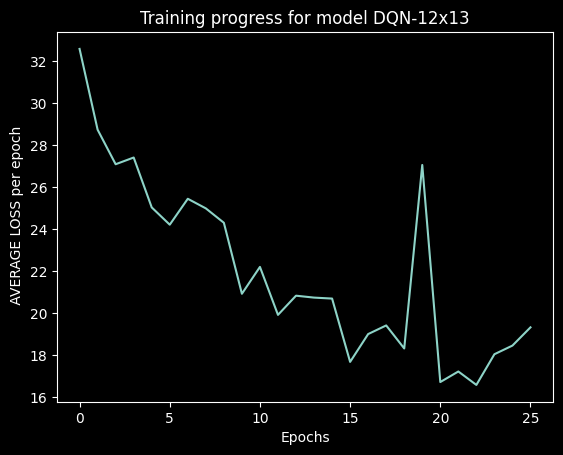

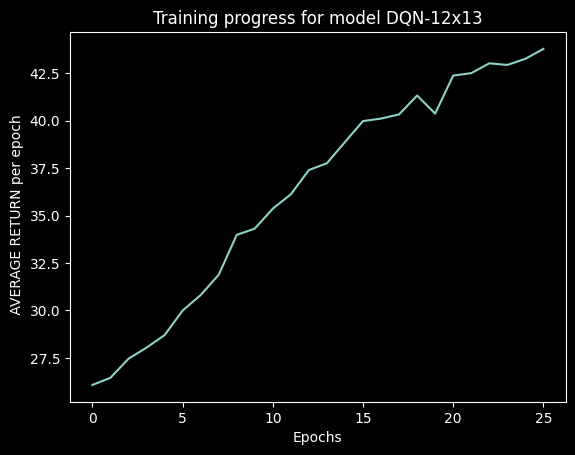

In [4]:
visualize_progress(dfs['6by7'], 'DQN-6x7', 'AVERAGE LOSS', './figures/6by7avgloss.png')
visualize_progress(dfs['6by7'], 'DQN-6x7', 'AVERAGE RETURN', './figures/6by7avgret.png')

visualize_progress(dfs['8by9'], 'DQN-8x9', 'AVERAGE LOSS', './figures/8by9avgloss.png')
visualize_progress(dfs['8by9'], 'DQN-8x9', 'AVERAGE RETURN', './figures/8by9avgret.png')

visualize_progress(dfs['10by11'], 'DQN-10x11', 'AVERAGE LOSS', './figures/10by11avgloss.png')
visualize_progress(dfs['10by11'], 'DQN-10x11', 'AVERAGE RETURN', './figures/10by11avgret.png')

visualize_progress(dfs['12by13'], 'DQN-12x13', 'AVERAGE LOSS', './figures/12by13avgloss.png')
visualize_progress(dfs['12by13'], 'DQN-12x13', 'AVERAGE RETURN', './figures/12by13avgret.png')

## Agent performance evaluation
Our goal is to evaluate the performance of each model against each other per grid size of the Environment.
If there is a significant advantage of one model over another based on statistics it can be called better.

### Agent initialization
We firstly initialize every agent we have.

In [5]:
minimax = MinimaxAgent()
random = RandomAgent()
lossavoid = AvoidNextLossAgent()

dqn = {}
dqn['6by7'] = ModelAgent('d6by7')
dqn['8by9'] = ModelAgent('d8by9')
dqn['10by11'] = ModelAgent('d10by11')
dqn['12by13'] = ModelAgent('d12by13')

neuroevo = NeuroevolutionAgent('Evolved_ANN.pickle')

### Writing the match functions and the pandas dataframe for storing the information

In [6]:
def match_agents(agent_a, agent_b, gridsize : tuple, playouts=100):
    '''
    Function for playout between two different agents on a Connect-Four grid of fixed size.
    Agents A and B will play against each other and statistics will be collected and stored in their object instance.
    Note that on uneven (even by index since it starts from 0) playouts A will be first to move and on even playouts B will have the first move.
    
    :param agent_a (): An agent who can play on the specified gridsize.
    :param agent_b (): An agent who can play on the specified gridsize.
    :param gridsize (tuple): A valid gridsize for the environment and agents, accepts (6,7), (8,9), (10,11), (12,13).
    :param playouts (int): The number of games to be played.
    '''
    
    env = ConnectFourEnv(gridsize)
    
    time_a = []
    time_b = []
    for i in tqdm(range(playouts),desc='Matches processed:'):
        env.reset() #reset environment once
        
        while not env.terminal:
            if (env.turn and (i % 2) == 0) or (not env.turn and (i % 2) == 1):
                starttime = datetime.now()
                action = agent_a.select_move(env)
                time_a += [(datetime.now()-starttime).microseconds*(10**-6)]
                env.step(action)
                
            elif (not env.turn and (i % 2) == 0) or (env.turn and (i % 2) == 1):
                starttime = datetime.now()
                action = agent_b.select_move(env)
                time_b += [(datetime.now()-starttime).microseconds*(10**-6)]
                env.step(action)
        
        #after each played match statistics of wins and time are gathered
        if (i % 2) == 0:
            if env.winner:
                agent_a.wins += 1
                agent_b.losses += 1
                
            else:
                agent_a.losses += 1
                agent_b.wins += 1
        else:
            if env.winner:
                agent_b.wins += 1
                agent_a.losses += 1
                
            else:
                agent_b.losses += 1
                agent_a.wins += 1
    
    #after every match was played the time statistics are added
    agent_a.average_speed = float(np.mean(time_a))
    agent_b.average_speed = float(np.mean(time_b))

### Now for each agent we can start to collect data and store it in a DataFrame

In [7]:
columns = ['AGENT A','AGENT B', 'GRID', 'A', 'B']
df = pd.DataFrame(columns=columns)
df

,AGENT A,AGENT B,GRID,A,B


In [8]:
name_for_idx = {0 : 'RandomAgent', 1 : 'AvoidNextLossAgent', 2 : 'MinimaxAgent', 3 : 'ModelAgent', 4 : 'NeuroevolutionAgent'}
for s_idx, gridsize in enumerate([(6, 7), (8, 9), (10, 11), (12, 13)]):
    for i, agent_a in enumerate([random, lossavoid, minimax, dqn, neuroevo]):
        for j, agent_b in enumerate([random, lossavoid, minimax, dqn, neuroevo]):
            if i != j and j > i and not (s_idx >= 1 and ((i == 4) or (j == 4))):
                print(f'Putting {name_for_idx[i]} vs {name_for_idx[j]} for grid size = {gridsize}:')
                
                if i == 3:
                    match_agents(agent_a[list(dqn.keys())[s_idx]], agent_b, gridsize)
                    appendix = pd.DataFrame([[name_for_idx[i],name_for_idx[j],str(gridsize),agent_a[list(dqn.keys())[s_idx]].wins,agent_b.wins]],columns=columns)
                    print(agent_a[list(dqn.keys())[s_idx]])
                    print(agent_b)
                    agent_a[list(dqn.keys())[s_idx]].reset()
                    agent_b.reset()
                    
                elif j == 3:
                    match_agents(agent_a, agent_b[list(dqn.keys())[s_idx]], gridsize)
                    appendix = pd.DataFrame([[name_for_idx[i],name_for_idx[j],str(gridsize),agent_a.wins,agent_b[list(dqn.keys())[s_idx]].wins]],columns=columns)
                    print(agent_a)
                    print(agent_b[list(dqn.keys())[s_idx]])
                    agent_a.reset()
                    agent_b[list(dqn.keys())[s_idx]].reset()
                    
                else:
                    match_agents(agent_a, agent_b, gridsize)
                    appendix = pd.DataFrame([[name_for_idx[i],name_for_idx[j],str(gridsize),agent_a.wins,agent_b.wins]],columns=columns)
                    print(agent_a)
                    print(agent_b)
                    agent_a.reset()
                    agent_b.reset()
                
                df = df.append(appendix)

Putting RandomAgent vs AvoidNextLossAgent for grid size = (6, 7):


Matches processed:: 100%|████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 95.56it/s]
C:\Users\marlo\AppData\Local\Temp\ipykernel_12360\3963148097.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(appendix)


Agent performance (52, 48, 100) with avg speed 3.607195571955719e-05 secs/move.
Agent performance (48, 52, 100) with avg speed 0.0006445398148148148 secs/move.
Putting RandomAgent vs MinimaxAgent for grid size = (6, 7):


Matches processed:: 100%|████████████████████████████████████████████████████████████| 100/100 [02:58<00:00,  1.79s/it]
C:\Users\marlo\AppData\Local\Temp\ipykernel_12360\3963148097.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(appendix)


Agent performance (3, 97, 100) with avg speed 5.046992481203007e-05 secs/move.
Agent performance (97, 3, 100) with avg speed 0.285429824 secs/move.
Putting RandomAgent vs ModelAgent for grid size = (6, 7):


Matches processed:: 100%|███████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 187.28it/s]
C:\Users\marlo\AppData\Local\Temp\ipykernel_12360\3963148097.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(appendix)


Agent performance (19, 81, 100) with avg speed 4.311066398390342e-05 secs/move.
Agent performance (81, 19, 100) with avg speed 0.0006494462365591397 secs/move.
Putting RandomAgent vs NeuroevolutionAgent for grid size = (6, 7):


Matches processed:: 100%|███████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 202.57it/s]
C:\Users\marlo\AppData\Local\Temp\ipykernel_12360\3963148097.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(appendix)


Agent performance (26, 74, 100) with avg speed 3.3201492537313434e-05 secs/move.
Agent performance (74, 26, 100) with avg speed 0.0003765132496513249 secs/move.
Putting AvoidNextLossAgent vs MinimaxAgent for grid size = (6, 7):


Matches processed:: 100%|████████████████████████████████████████████████████████████| 100/100 [03:03<00:00,  1.84s/it]
C:\Users\marlo\AppData\Local\Temp\ipykernel_12360\3963148097.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(appendix)


Agent performance (5, 95, 100) with avg speed 0.0007237769516728623 secs/move.
Agent performance (95, 5, 100) with avg speed 0.29207320574162676 secs/move.
Putting AvoidNextLossAgent vs ModelAgent for grid size = (6, 7):


Matches processed:: 100%|███████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 115.68it/s]
C:\Users\marlo\AppData\Local\Temp\ipykernel_12360\3963148097.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(appendix)


Agent performance (15, 85, 100) with avg speed 0.0006926329670329668 secs/move.
Agent performance (85, 15, 100) with avg speed 0.0007908721374045802 secs/move.
Putting AvoidNextLossAgent vs NeuroevolutionAgent for grid size = (6, 7):


Matches processed:: 100%|████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 94.14it/s]
C:\Users\marlo\AppData\Local\Temp\ipykernel_12360\3963148097.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(appendix)


Agent performance (38, 62, 100) with avg speed 0.000677685408299866 secs/move.
Agent performance (62, 38, 100) with avg speed 0.00041594941634241246 secs/move.
Putting MinimaxAgent vs ModelAgent for grid size = (6, 7):


Matches processed:: 100%|████████████████████████████████████████████████████████████| 100/100 [03:59<00:00,  2.40s/it]
C:\Users\marlo\AppData\Local\Temp\ipykernel_12360\3963148097.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(appendix)


Agent performance (100, 0, 100) with avg speed 0.29848753874999995 secs/move.
Agent performance (0, 100, 100) with avg speed 0.0009297957142857143 secs/move.
Putting MinimaxAgent vs NeuroevolutionAgent for grid size = (6, 7):


Matches processed:: 100%|████████████████████████████████████████████████████████████| 100/100 [08:50<00:00,  5.30s/it]
C:\Users\marlo\AppData\Local\Temp\ipykernel_12360\3963148097.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(appendix)


Agent performance (50, 50, 100) with avg speed 0.2935022911111111 secs/move.
Agent performance (50, 50, 100) with avg speed 0.000557908 secs/move.
Putting ModelAgent vs NeuroevolutionAgent for grid size = (6, 7):


Matches processed:: 100%|████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 64.52it/s]
C:\Users\marlo\AppData\Local\Temp\ipykernel_12360\3963148097.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(appendix)


Agent performance (0, 100, 100) with avg speed 0.0008231282306163021 secs/move.
Agent performance (100, 0, 100) with avg speed 0.00041979728506787324 secs/move.
Putting RandomAgent vs AvoidNextLossAgent for grid size = (8, 9):


Matches processed:: 100%|████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 73.24it/s]
C:\Users\marlo\AppData\Local\Temp\ipykernel_12360\3963148097.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(appendix)


Agent performance (47, 53, 100) with avg speed 3.6351602023608765e-05 secs/move.
Agent performance (53, 47, 100) with avg speed 0.0008015427852348994 secs/move.
Putting RandomAgent vs MinimaxAgent for grid size = (8, 9):


Matches processed:: 100%|████████████████████████████████████████████████████████████| 100/100 [05:49<00:00,  3.50s/it]
C:\Users\marlo\AppData\Local\Temp\ipykernel_12360\3963148097.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(appendix)


Agent performance (3, 97, 100) with avg speed 5.220833333333333e-05 secs/move.
Agent performance (97, 3, 100) with avg speed 0.6366334681238616 secs/move.
Putting RandomAgent vs ModelAgent for grid size = (8, 9):


Matches processed:: 100%|███████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 134.38it/s]
C:\Users\marlo\AppData\Local\Temp\ipykernel_12360\3963148097.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(appendix)


Agent performance (5, 95, 100) with avg speed 3.825934065934066e-05 secs/move.
Agent performance (95, 5, 100) with avg speed 0.0010369816176470587 secs/move.
Putting AvoidNextLossAgent vs MinimaxAgent for grid size = (8, 9):


Matches processed:: 100%|████████████████████████████████████████████████████████████| 100/100 [05:16<00:00,  3.16s/it]
C:\Users\marlo\AppData\Local\Temp\ipykernel_12360\3963148097.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(appendix)


Agent performance (2, 98, 100) with avg speed 0.0009248913580246913 secs/move.
Agent performance (98, 2, 100) with avg speed 0.6310133579999999 secs/move.
Putting AvoidNextLossAgent vs ModelAgent for grid size = (8, 9):


Matches processed:: 100%|████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 82.05it/s]
C:\Users\marlo\AppData\Local\Temp\ipykernel_12360\3963148097.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(appendix)


Agent performance (8, 92, 100) with avg speed 0.0008336144329896906 secs/move.
Agent performance (92, 8, 100) with avg speed 0.0011214894366197183 secs/move.
Putting MinimaxAgent vs ModelAgent for grid size = (8, 9):


Matches processed:: 100%|████████████████████████████████████████████████████████████| 100/100 [21:05<00:00, 12.65s/it]
C:\Users\marlo\AppData\Local\Temp\ipykernel_12360\3963148097.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(appendix)


Agent performance (100, 0, 100) with avg speed 0.6310608035 secs/move.
Agent performance (0, 100, 100) with avg speed 0.0011947073684210525 secs/move.
Putting RandomAgent vs AvoidNextLossAgent for grid size = (10, 11):


Matches processed:: 100%|████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 57.49it/s]
C:\Users\marlo\AppData\Local\Temp\ipykernel_12360\3963148097.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(appendix)


Agent performance (37, 63, 100) with avg speed 3.7319935691318324e-05 secs/move.
Agent performance (63, 37, 100) with avg speed 0.0010019732283464567 secs/move.
Putting RandomAgent vs MinimaxAgent for grid size = (10, 11):


Matches processed:: 100%|████████████████████████████████████████████████████████████| 100/100 [09:46<00:00,  5.86s/it]
C:\Users\marlo\AppData\Local\Temp\ipykernel_12360\3963148097.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(appendix)


Agent performance (1, 99, 100) with avg speed 8.176847290640396e-05 secs/move.
Agent performance (99, 1, 100) with avg speed 0.1650304930417495 secs/move.
Putting RandomAgent vs ModelAgent for grid size = (10, 11):


Matches processed:: 100%|███████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 107.28it/s]
C:\Users\marlo\AppData\Local\Temp\ipykernel_12360\3963148097.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(appendix)


Agent performance (2, 98, 100) with avg speed 5.085754985754986e-05 secs/move.
Agent performance (98, 2, 100) with avg speed 0.001742645739910314 secs/move.
Putting AvoidNextLossAgent vs MinimaxAgent for grid size = (10, 11):


Matches processed:: 100%|████████████████████████████████████████████████████████████| 100/100 [09:15<00:00,  5.56s/it]
C:\Users\marlo\AppData\Local\Temp\ipykernel_12360\3963148097.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(appendix)


Agent performance (1, 99, 100) with avg speed 0.0011306992084432717 secs/move.
Agent performance (99, 1, 100) with avg speed 0.16559377310924367 secs/move.
Putting AvoidNextLossAgent vs ModelAgent for grid size = (10, 11):


Matches processed:: 100%|████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 73.91it/s]
C:\Users\marlo\AppData\Local\Temp\ipykernel_12360\3963148097.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(appendix)


Agent performance (1, 99, 100) with avg speed 0.0010173240997229916 secs/move.
Agent performance (99, 1, 100) with avg speed 0.0018467096069868995 secs/move.
Putting MinimaxAgent vs ModelAgent for grid size = (10, 11):


Matches processed:: 100%|████████████████████████████████████████████████████████████| 100/100 [23:56<00:00, 14.37s/it]
C:\Users\marlo\AppData\Local\Temp\ipykernel_12360\3963148097.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(appendix)


Agent performance (100, 0, 100) with avg speed 0.1948025275 secs/move.
Agent performance (0, 100, 100) with avg speed 0.0019450354545454546 secs/move.
Putting RandomAgent vs AvoidNextLossAgent for grid size = (12, 13):


Matches processed:: 100%|████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 45.50it/s]
C:\Users\marlo\AppData\Local\Temp\ipykernel_12360\3963148097.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(appendix)


Agent performance (48, 52, 100) with avg speed 4.5628612716763005e-05 secs/move.
Agent performance (52, 48, 100) with avg speed 0.0011945465032444124 secs/move.
Putting RandomAgent vs MinimaxAgent for grid size = (12, 13):


Matches processed:: 100%|████████████████████████████████████████████████████████████| 100/100 [15:50<00:00,  9.50s/it]
C:\Users\marlo\AppData\Local\Temp\ipykernel_12360\3963148097.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(appendix)


Agent performance (1, 99, 100) with avg speed 8.426592797783933e-05 secs/move.
Agent performance (99, 1, 100) with avg speed 0.44780889082969433 secs/move.
Putting RandomAgent vs ModelAgent for grid size = (12, 13):


Matches processed:: 100%|███████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 106.21it/s]
C:\Users\marlo\AppData\Local\Temp\ipykernel_12360\3963148097.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(appendix)


Agent performance (0, 100, 100) with avg speed 3.106122448979592e-05 secs/move.
Agent performance (100, 0, 100) with avg speed 0.0018167443438914025 secs/move.
Putting AvoidNextLossAgent vs MinimaxAgent for grid size = (12, 13):


Matches processed:: 100%|████████████████████████████████████████████████████████████| 100/100 [16:53<00:00, 10.14s/it]
C:\Users\marlo\AppData\Local\Temp\ipykernel_12360\3963148097.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(appendix)


Agent performance (0, 100, 100) with avg speed 0.0013453246073298428 secs/move.
Agent performance (100, 0, 100) with avg speed 0.29440786070686065 secs/move.
Putting AvoidNextLossAgent vs ModelAgent for grid size = (12, 13):


Matches processed:: 100%|████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 65.53it/s]
C:\Users\marlo\AppData\Local\Temp\ipykernel_12360\3963148097.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(appendix)


Agent performance (0, 100, 100) with avg speed 0.0011889035812672176 secs/move.
Agent performance (100, 0, 100) with avg speed 0.0019255800865800863 secs/move.
Putting MinimaxAgent vs ModelAgent for grid size = (12, 13):


Matches processed:: 100%|████████████████████████████████████████████████████████████| 100/100 [50:11<00:00, 30.11s/it]

Agent performance (100, 0, 100) with avg speed 0.18222520214285712 secs/move.
Agent performance (0, 100, 100) with avg speed 0.0015156423076923076 secs/move.



C:\Users\marlo\AppData\Local\Temp\ipykernel_12360\3963148097.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(appendix)


In [9]:
df.head()

,AGENT A,AGENT B,GRID,A,B
0,RandomAgent,AvoidNextLossAgent,"(6, 7)",52,48
0,RandomAgent,MinimaxAgent,"(6, 7)",3,97
0,RandomAgent,ModelAgent,"(6, 7)",19,81
0,RandomAgent,NeuroevolutionAgent,"(6, 7)",26,74
0,AvoidNextLossAgent,MinimaxAgent,"(6, 7)",5,95


In [10]:
df.to_csv('./performance_data.csv',index=None)

In [44]:
def bar_label_plot(gsize : tuple, matchups : list, agent_a_wins : tuple, agent_b_wins : tuple):
    '''
    Draws a bar label plot and saves it for later use.
    Code was taken from "https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html#sphx-glr-gallery-lines-bars-and-markers-bar-label-demo-py".
    Code was then modified to fit our purpose.
    '''
    
    N = len(matchups)
    ind = np.arange(N)
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(15,4))
    plt.style.use('dark_background')
    
    p1 = ax.bar(ind, agent_a_wins, width, label='Agent A', color='red')
    p2 = ax.bar(ind, agent_b_wins, width, bottom=agent_a_wins, label='Agent B', color='green')

    ax.axhline(0, color='grey', linewidth=0.8)
    ax.set_ylabel('Wins')
    ax.set_title(f'Agent performance against each other for gridsize {gsize} with n=100 samples.')
    ax.set_xticks(ind, labels=matchups)
    ax.legend()

    ax.bar_label(p1, label_type='center')
    ax.bar_label(p2, label_type='center')
    
    fig.savefig(f'./figures/modelperfom{gsize}.png')
    plt.show()

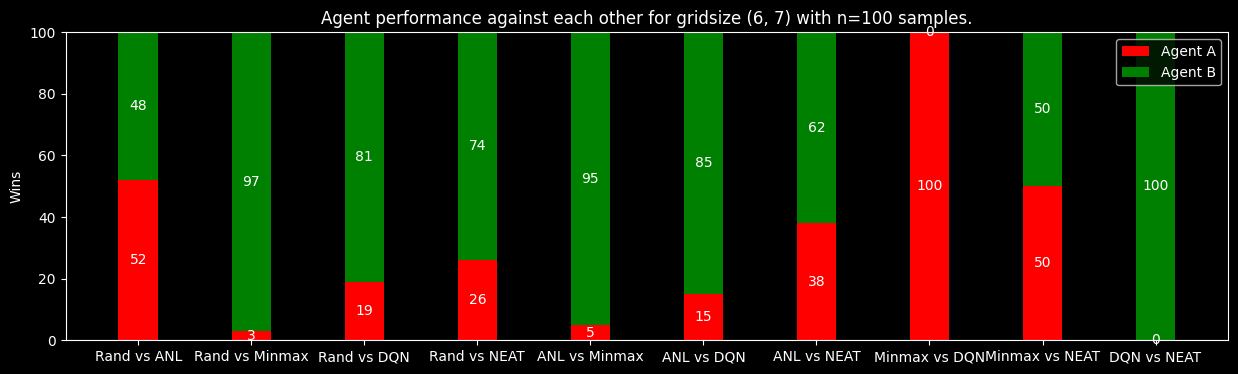

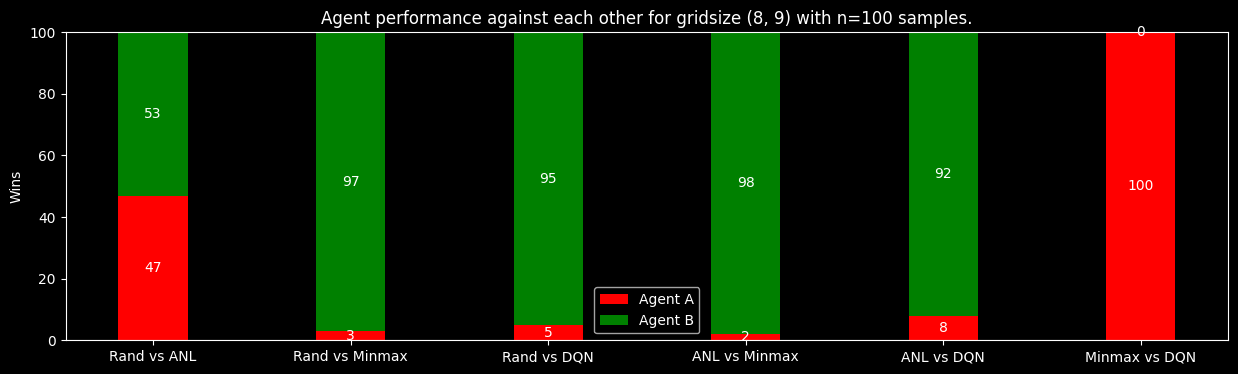

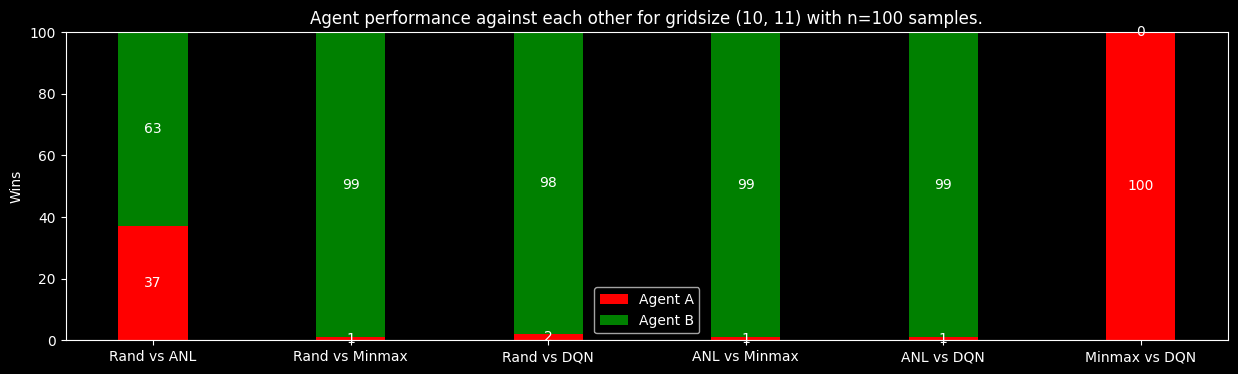

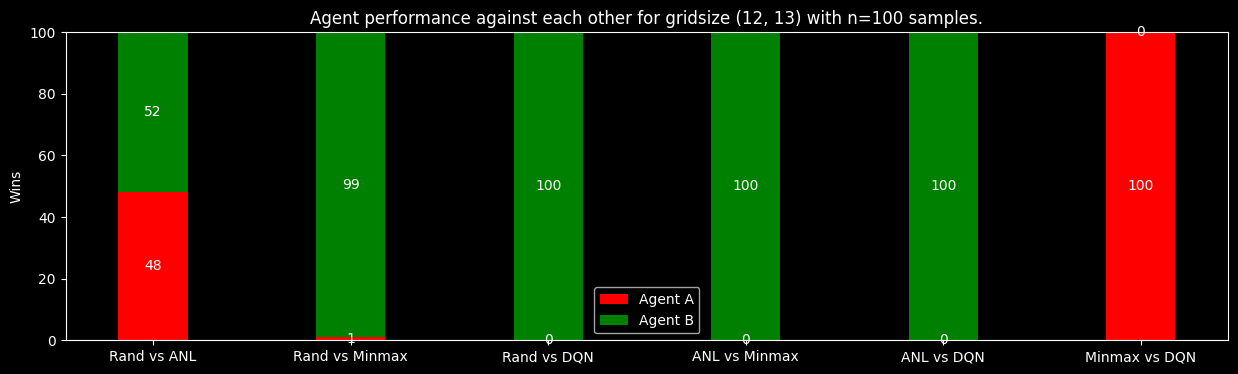

In [45]:
matchups_6x7 = ["Rand vs ANL",
                "Rand vs Minmax",
                "Rand vs DQN",
                "Rand vs NEAT",
                "ANL vs Minmax",
                "ANL vs DQN",
                "ANL vs NEAT",
                "Minmax vs DQN",
                "Minmax vs NEAT",
                "DQN vs NEAT"]

matchups_other = ["Rand vs ANL",
                "Rand vs Minmax",
                "Rand vs DQN",
                "ANL vs Minmax",
                "ANL vs DQN",
                "Minmax vs DQN"]

results_a = list(df['A'])
results_a = [results_a[:10], results_a[10:16],results_a[16:22],results_a[22:]]

results_b = list(df['B'])
results_b = [results_b[:10], results_b[10:16],results_b[16:22],results_b[22:]]

bar_label_plot((6,7), matchups_6x7, tuple(results_a[0]), tuple(results_b[0]))
bar_label_plot((8,9), matchups_other, tuple(results_a[1]), tuple(results_b[1]))
bar_label_plot((10,11), matchups_other, tuple(results_a[2]), tuple(results_b[2]))
bar_label_plot((12,13), matchups_other, tuple(results_a[3]), tuple(results_b[3]))